In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split
from sklearn.naive_bayes import MultinomialNB

import enchant
pd.set_option('display.max_rows', 500)

In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

varcluster_info=pd.DataFrame(
{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
})

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100)]

In [3]:
merged_data=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")
merged_data=merged_data[pd.isnull(merged_data["Category"])==False]

In [4]:
dummies=pd.get_dummies(merged_data['Category'])
merged_data=pd.concat([merged_data,dummies], axis=1,ignore_index=False)

In [5]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000) #ngram_range=(2, 2)
review_vectors = vectorizer.fit_transform(merged_data["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
merged_data.reset_index(drop=True, inplace=True)
merged_data=pd.concat([merged_data,features_df], axis=1,ignore_index=False)

wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

In [6]:
pca = PCA(n_components=2).fit_transform(merged_data[merged_data.columns[16:]])
concated_ds=pd.concat([pd.DataFrame(pca),merged_data], ignore_index=True, axis=1)
concated_ds.columns=['PCA_1','PCA_2']+merged_data.columns.tolist()
merged_data=concated_ds

In [7]:
merged_data.Category=merged_data.Category.str.strip()

In [8]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varcluster=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')

In [9]:
## Removing the General cluster columns
merged_data=merged_data.drop(columns=merged_data.columns[merged_data.columns.isin(varcluster[varcluster.category=='General'].Variable)])

In [10]:
## Removing the columns that are far away from of cluster
merged_data=merged_data.drop(columns=merged_data.columns[merged_data.columns.isin(varcluster[varcluster.RS_Ratio>=1].Variable)])

In [11]:
## Other variable cluster with same category analysis

#catfiltered_ds=merged_data[merged_data.Category=='Engineering Sciences ']
#othercolumns=merged_data.columns[~merged_data.columns.isin(varcluster[varcluster.category=='Engineering Sciences'].Variable)]
#merged_data[['Description','File_Categories','Category']].loc[catfiltered_ds[othercolumns[15:]].head().T.sum().index]

In [14]:
#Filename='DBScanCluster.csv'
#NewMergedDS=pd.read_csv(Path+Filename)

In [15]:
print(str(datetime.datetime.now())+" : Started ")

CategoricalDS1=merged_data[merged_data.Category=='Engineering Sciences']

Features=CategoricalDS1[CategoricalDS1.columns[18:]]
DBScanDS1 = DBSCAN(eps=.95, min_samples=2, n_jobs=4).fit_predict(Features)

CategoricalDS1['DBScanCluster']=DBScanDS1

CategoricalDS2=merged_data[merged_data.Category=='Humanities and Social Sciences']

Features=CategoricalDS2[CategoricalDS2.columns[18:]]
DBScanDS2 = DBSCAN(eps=.95, min_samples=2, n_jobs=4).fit_predict(Features)

CategoricalDS2['DBScanCluster']=DBScanDS2

CategoricalDS3=merged_data[merged_data.Category=='Life Sciences']

Features=CategoricalDS3[CategoricalDS3.columns[18:]]
DBScanDS3 = DBSCAN(eps=.95, min_samples=2, n_jobs=4).fit_predict(Features)

CategoricalDS3['DBScanCluster']=DBScanDS3

CategoricalDS4=merged_data[merged_data.Category=='Natural Sciences']

Features=CategoricalDS4[CategoricalDS4.columns[18:]]
DBScanDS4 = DBSCAN(eps=.95, min_samples=2, n_jobs=4).fit_predict(Features)

CategoricalDS4['DBScanCluster']=DBScanDS4

NewMergedDS=pd.concat([CategoricalDS1,CategoricalDS2,CategoricalDS3,CategoricalDS4])

#NewMergedDS[NewMergedDS.columns[:14].tolist()+['DBScanCluster']].to_csv(Path+'DBScanCluster.csv', index=False)

print(str(datetime.datetime.now())+" : Completed ")

2020-01-01 23:21:57.234775 : Started 


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

2020-01-01 23:40:47.867152 : Completed 


In [16]:
#NewMergedDS.DBScanCluster.value_counts()
NewMergedDS['Category'].value_counts()

Life Sciences                     18201
Natural Sciences                  13985
Humanities and Social Sciences    10218
Engineering Sciences               9410
Name: Category, dtype: int64

In [17]:
NewMergedDS['CategoryConv']=''
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Engineering Sciences']=0
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Humanities and Social Sciences']=1
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Natural Sciences']=2
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Life Sciences']=3

NewMergedDS['CategoryConv']=NewMergedDS['CategoryConv'].astype('int')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/U

In [18]:
Features=NewMergedDS.columns[18:len(NewMergedDS.columns)-1]
OP_Feature='CategoryConv'

X_Training_DS=NewMergedDS[Features][NewMergedDS.DBScanCluster==0]
y_Training_DS=NewMergedDS[OP_Feature][NewMergedDS.DBScanCluster==0]

X_Test_DS=NewMergedDS[Features][NewMergedDS.DBScanCluster!=0]
y_Test_DS=NewMergedDS[OP_Feature][NewMergedDS.DBScanCluster!=0]


Text(0.5, 1.0, 'Accuracy_score from 5 Folds (Accuracy) for ')

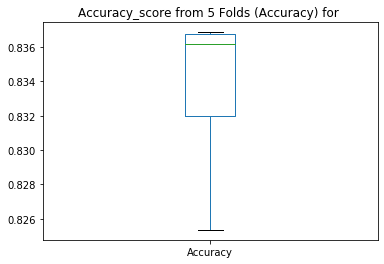

In [20]:
modelNB = MultinomialNB(alpha=.5)
modelNB.fit(X_Training_DS, y_Training_DS)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for ')

In [21]:
def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''

In [22]:
#matching_category()
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelNB.predict_log_proba(NewMergedDS[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [23]:
#NewMergedDSAligned.columns
NewMergedDS.columns.tolist()[2:16]+['DBScanCluster']

['Name',
 'SubUrl',
 'FundingFrom',
 'FundingEnd',
 'SubjectArea',
 'Institution',
 'Description',
 'Translates',
 'Name_Translated',
 'PreProcessedDescription',
 'File_Categories',
 'Category',
 'Engineering Sciences ',
 'Humanities and Social Sciences',
 'DBScanCluster']

In [24]:
NewMergedDSAligned=pd.concat([NewMergedDS[NewMergedDS.columns.tolist()[2:16]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [25]:
#NewMergedDS=NewMergedDS.reset_index()
#NewMergedDS[NewMergedDS.columns.tolist()[2:16]].head()

NewMergedDSAligned.head()

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,Humanities and Social Sciences,DBScanCluster,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
0,GRK 6:&nbsp; Spatial Statistics,/gepris/projekt/268853,1997,2003,Mathematics,Technische Universität Bergakademie Freiberg,The work of the research training group is dir...,The work of the research training group is dir...,GRK 6:&nbsp; Spatial Statistics,work research training group direct model meth...,...,0,0,-0.747666,-0.904639,-2.210077,Engineering Sciences,Natural Sciences,Life Sciences,0.156973,1.305438
1,GRK 12:&nbsp; Migration in Modern Europe,/gepris/projekt/268931,1995,2004,Social Sciences,Universität Osnabrück,The subject of the research training group 'Mi...,The subject of the research training group 'Mi...,GRK 12:&nbsp; Migration in Modern Europe,subject research training group migration mode...,...,1,0,-0.571061,-1.464608,-1.751213,Engineering Sciences,Natural Sciences,Humanities and Social Sciences,0.893547,0.286605
2,GRK 45:&nbsp; Integrated Fluidical Sensor-Actu...,/gepris/projekt/269237,1995,2004,Production Technology,Universität Rostock,The goal of this program consists in the mathe...,The goal of this program consists in the mathe...,GRK 45:&nbsp; Integrated Fluidical Sensor-Actu...,goal program consist mathematical formulation ...,...,0,0,-1.032566,-1.054995,-1.424807,Natural Sciences,Engineering Sciences,Humanities and Social Sciences,0.022429,0.369812
3,GRK 52:&nbsp; Quantum Field Theory: Mathematic...,/gepris/projekt/269303,1995,2004,Condensed Matter Physics,Universität Leipzig,The aim of the research training group is to p...,The aim of the research training group is to p...,GRK 52:&nbsp; Quantum Field Theory: Mathematic...,aim research training group pass generation sc...,...,0,0,-0.428796,-1.116335,-4.496459,Engineering Sciences,Natural Sciences,Life Sciences,0.687539,3.380124
4,GRK 115:&nbsp; Ocean Engineering Structures,/gepris/projekt/269869,1995,2004,Construction Engineering and Architecture,Technische Universität Hamburg,Ocean engineering encompasses a wide variety o...,Ocean engineering encompasses a wide variety o...,GRK 115:&nbsp; Ocean Engineering Structures,ocean engineering encompass wide variety area ...,...,0,0,-0.856409,-1.317699,-1.568552,Engineering Sciences,Humanities and Social Sciences,Natural Sciences,0.461290,0.250853


In [26]:
NewMergedDSAligned.columns

Index(['Name', 'SubUrl', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'Description', 'Translates', 'Name_Translated',
       'PreProcessedDescription', 'File_Categories', 'Category',
       'Engineering Sciences ', 'Humanities and Social Sciences',
       'DBScanCluster', 'Category_1_Values', 'Category_2_Values',
       'Category_3_Values', 'Category_1', 'Category_2', 'Category_3',
       'Category_12_Variance', 'Category_23_Variance'],
      dtype='object')

In [27]:
#NewMergedDSAligned.to_csv(Path+'DBScanNBFindings.csv', index=False)

In [40]:
NewMergedDSAligned['DBScanCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 0    36692
-1     1005
 1        6
 3        3
 2        2
 6        1
 5        1
 4        1
Name: DBScanCluster, dtype: int64

In [34]:
NewMergedDSAligned['DBScanCluster'][(NewMergedDSAligned['Category']==NewMergedDSAligned['Category_1'])].value_counts()

 0    13697
-1      397
 7        2
 3        2
 2        2
 6        1
 5        1
 4        1
Name: DBScanCluster, dtype: int64

In [30]:
NewMergedDSAligned['DBScanCluster'][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

-1    1005
 1       6
 3       3
 2       2
 6       1
 5       1
 4       1
Name: DBScanCluster, dtype: int64

In [41]:
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(120).tail().tolist()

['The cellular amount of certain key regulatory factors is the result of a highly dynamic and regulated balance between regulation of synthesis and degradation. Using the multiple stress-inhibited proteolysis of the Sigma-S subunit of RNA polymerase in E.coli as a model system, the proposal submitted here focusses on the two major unsolved problems in the field of regulated proteolysis: (i) the molecular details of selective substrate recognition by the proteolytic machinery, and (ii) the signal transduction pathways that connect environmental stress conditions to the rate of proteolysis of a key cellular regulator. Sigma-S is directly targeted by a recognition factor, RssB, whose affinity for a small region within Sigma-S (a2.5) is controlled by phosphorylation. RssB then transfers Sigma-S to the ClpXP protease, where Sigma-S is rapidly and completely degraded. Molecular interactions between proteolytic recognition sites in Sigma-S (and probably in Sigma-70) and various recognizing fa

In [42]:
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(120).tail()

,Translates,Category,Humanities and Social Sciences,DBScanCluster,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
9419,The cellular amount of certain key regulatory ...,Life Sciences,0,-1,-0.004827,-5.904253,-6.791650,Humanities and Social Sciences,Natural Sciences,Engineering Sciences,5.899425,0.887397
16748,Aim and objective is the co-ordinated handling...,Life Sciences,0,-1,-0.004882,-5.877112,-6.495285,Humanities and Social Sciences,Natural Sciences,Engineering Sciences,5.872230,0.618173
21533,CO2 is an environment-friendly solvent that ca...,Engineering Sciences,0,-1,-0.004939,-5.801209,-6.363689,Life Sciences,Natural Sciences,Engineering Sciences,5.796270,0.562480
25067,Fixed-solid phase transitions in shape-memory ...,Natural Sciences,0,-1,-0.005369,-5.871581,-6.389984,Life Sciences,Humanities and Social Sciences,Natural Sciences,5.866212,0.518403
18167,The phenotypic characteristics of Staphylococc...,Life Sciences,0,-1,-0.005401,-5.879536,-6.209428,Humanities and Social Sciences,Engineering Sciences,Natural Sciences,5.874136,0.329892


In [46]:
cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_12_Variance']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_12_Variance', ascending=False).Translates.head(100).tolist()#.tail().

["The University of Pennsylvania Museum of Archeology and Anthropology, Philadelphia (USA) owns one of the world's three largest collections of artifacts from the royal tombs of Ur. Its breadth and diversity demonstrate an extraordinarily high degree of technological know-how as well as far-reaching economic trade relations of the city in the middle of the 3rd millennium BC. The artifacts occupy a key position in the history of metallurgy and economics as well as the craftsmanship of Mesopotamia. Applicants have been invited by the University Museum in Philadelphia to undertake an extensive analytical study, especially of metal artefacts. It is planned, in collaboration with archaeologists on the basis of isotopic (lead, copper and osmium isotope), geochemical and mineralogical analyzes, provenance issues and applied metallurgical (alloy) techniques as a contribution to the clarification of Mesopotamian cultural interactions with the countries around Afghanistan, the Industalkultur and

In [48]:
#cats='Natural Sciences'
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[14:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_12_Variance', ascending=False).head(100)

,Translates,Category,DBScanCluster,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
34335,The University of Pennsylvania Museum of Arche...,Humanities and Social Sciences,-1,-0.000036,-10.689450,-11.403630,Life Sciences,Natural Sciences,Humanities and Social Sciences,10.689415,0.714180
26522,The subproject investigates how modern technol...,Humanities and Social Sciences,-1,-0.000160,-9.299316,-9.813746,Life Sciences,Humanities and Social Sciences,Natural Sciences,9.299156,0.514430
33672,The proposed project is a substantive analysis...,Humanities and Social Sciences,-1,-0.000145,-9.140069,-10.471728,Life Sciences,Natural Sciences,Engineering Sciences,9.139925,1.331659
32956,Procurement auctions are used to award public ...,Humanities and Social Sciences,-1,-0.000152,-9.134410,-10.330844,Life Sciences,Natural Sciences,Engineering Sciences,9.134258,1.196434
36012,The goal of this project is the comparative sy...,Humanities and Social Sciences,-1,-0.000160,-9.128976,-10.182260,Life Sciences,Natural Sciences,Humanities and Social Sciences,9.128816,1.053284
26480,The subproject explores the composition and tr...,Humanities and Social Sciences,-1,-0.000210,-8.851858,-9.992978,Life Sciences,Natural Sciences,Humanities and Social Sciences,8.851648,1.141120
34665,The subproject intends to investigate the theo...,Humanities and Social Sciences,-1,-0.000216,-8.602130,-10.982951,Life Sciences,Natural Sciences,Engineering Sciences,8.601914,2.380820
20148,"Germanic mythology - handed down v.a. In two ""...",Humanities and Social Sciences,-1,-0.000508,-8.182510,-8.514337,Life Sciences,Natural Sciences,Engineering Sciences,8.182002,0.331827
22652,The project examines the relationship between ...,Humanities and Social Sciences,-1,-0.000414,-7.904613,-10.526853,Life Sciences,Natural Sciences,Humanities and Social Sciences,7.904199,2.622239
35783,The turmoil of the financial crisis provokes t...,Humanities and Social Sciences,-1,-0.001001,-7.768016,-7.861514,Life Sciences,Engineering Sciences,Natural Sciences,7.767015,0.093499
